## LATIHAN ARIMA-TRANSFORMER

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, shapiro, anderson
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

In [2]:
import tensorflow as tf
import keras

print(tf.__version__, keras.__version__)

2.18.0 3.8.0


In [3]:
data_df = pd.read_excel('residual_arima.xlsx')
columns_name = ['Residual']
Data = pd.DataFrame(data_df, columns=columns_name)
time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d/%m/%Y')
data_df.set_index('Date', inplace=True)

In [4]:
print(data_df.columns)

Index(['Residual'], dtype='object')


In [5]:
Data.tail()

,Residual
414,-3.703587
415,1.189531
416,6.300080
417,11.394392
418,17.084002


In [6]:
def add_lag_features(data_df, lags):
    for lag in lags:
        column_name_lag = f'lag_{lag}'
        data_df[column_name_lag] = data_df['Residual'].shift(lag)

def add_rolling_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_min = f'rolling_min_{window_size}'
        column_name_max = f'rolling_max_{window_size}'
        column_name_ma = f'moving_average_{window_size}'
        column_name_ema = f'ema_{window_size}'
        column_name_std = f'moving_std_{window_size}'
        column_name_median = f'moving_median_{window_size}'

        data_df[column_name_min] = data_df['Residual'].rolling(window=window_size).min()
        data_df[column_name_max] = data_df['Residual'].rolling(window=window_size).max()
        data_df[column_name_ma] = data_df['Residual'].rolling(window=window_size).mean()
        data_df[column_name_ema] = data_df['Residual'].ewm(span=window_size, adjust=False).mean()
        data_df[column_name_std] = data_df['Residual'].rolling(window=window_size).std()
        data_df[column_name_median] = data_df['Residual'].rolling(window=window_size).median()

def add_interaction_features(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_interaction = f'interaction_ma_ema_{window_size}'
        data_df[column_name_interaction] = data_df[f'moving_average_{window_size}'] * data_df[f'ema_{window_size}']

def add_seasonal_features(data_df):
    data_df['quarter'] = data_df.index.quarter
    data_df['year'] = data_df.index.year

def add_rate_of_change(data_df, lags):
    for lag in lags:
        column_name_roc = f'roc_{lag}'
        data_df[column_name_roc] = (data_df['Residual'] - data_df['Residual'].shift(lag)) / data_df['Residual'].shift(lag)

def add_cumulative_sum(data_df):
    data_df['cumulative_sum'] = data_df['Residual'].cumsum()

def add_ewma_std(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_ewma_std = f'ewma_std_{window_size}'
        data_df[column_name_ewma_std] = data_df['Residual'].ewm(span=window_size, adjust=False).std()

def add_additional_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_lagged_ma = f'lagged_ma_{window_size}'
        column_name_lagged_ema = f'lagged_ema_{window_size}'
        column_name_acf = f'autocorr_{window_size}'

        data_df[column_name_lagged_ma] = data_df[f'moving_average_{window_size}'].shift(1)
        data_df[column_name_lagged_ema] = data_df[f'ema_{window_size}'].shift(1)
        data_df[column_name_acf] = data_df['Residual'].autocorr(lag=window_size)

def add_z_scores(data_df):
    # Z-Score based on standard deviation
    data_df['z_score'] = (data_df['Residual'] - data_df['Residual'].mean()) / data_df['Residual'].std()

    # Z-Score based on median and median absolute deviation (MAD)
    median = data_df['Residual'].median()
    mad = np.median(np.abs(data_df['Residual'] - median))
    data_df['mad_z_score'] = (data_df['Residual'] - median) / mad

def add_log_returns(data_df):
    data_df['log_returns'] = np.log(data_df['Residual'] / data_df['Residual'].shift(1))


# List of lags for lag features
lags = [1, 2, 3]
# Lags represent the time intervals used to shift and create lag features, capturing historical values at different points in the past.

# List of window sizes for rolling statistics and other features
window_sizes = [2, 3, 12, 24, 28, 36]
# Window sizes determine the size of the rolling windows used for calculating statistics and features. Different sizes capture varying trends and patterns over specified periods.


add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

data_df_drop = data_df.dropna()

In [7]:
data_df_drop.head()

,Residual,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,moving_std_2,moving_median_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,5.251438,3.082590,0.753469,0.228550,3.082590,5.251438,4.167014,4.247549,1.533607,4.167014,...,0.247801,4.522278,2.617142,0.189953,0.697574,3.620826,-0.058656,0.316083,0.502550,0.532732
1990-02-01,6.715485,5.251438,3.082590,0.753469,5.251438,6.715485,5.983462,5.892839,1.035237,5.983462,...,0.247801,5.895042,2.798818,0.189953,0.341530,3.708968,-0.058656,0.412937,0.712873,0.245914
1990-03-01,4.836575,6.715485,5.251438,3.082590,4.836575,6.715485,5.776030,5.188663,1.328590,5.776030,...,0.247801,6.773357,3.068933,0.189953,0.270476,3.871482,-0.058656,0.288638,0.442951,-0.328209
1990-04-01,9.230476,4.836575,6.715485,5.251438,4.836575,9.230476,7.033526,7.883205,3.106958,7.033526,...,0.247801,7.000636,3.190839,0.189953,0.364140,3.923649,-0.058656,0.579315,1.074173,0.646304
1990-05-01,10.627830,9.230476,4.836575,6.715485,9.230476,10.627830,9.929153,9.712955,0.988078,9.929153,...,0.247801,6.978050,3.607366,0.189953,0.801062,4.210505,-0.058656,0.671757,1.274914,0.140965


In [8]:
data_df_drop.tail()

,Residual,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,moving_std_2,moving_median_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-01,-8.350073,-13.593567,-18.363713,-20.349432,-13.593567,-8.350073,-10.971820,-10.629773,3.707710,-10.971820,...,0.247801,-9.470168,-6.071614,0.189953,-7.919524,-5.895148,-0.058656,-0.583721,-1.451423,-0.487326
2021-07-01,-3.703587,-8.350073,-13.593567,-18.363713,-8.350073,-3.703587,-6.026830,-6.012315,3.285562,-6.026830,...,0.247801,-9.181161,-6.228749,0.189953,-8.223606,-6.027847,-0.058656,-0.276334,-0.783916,-0.812968
2021-09-01,6.300080,1.189531,-3.703587,-8.350073,1.189531,6.300080,3.744806,3.796359,3.613704,3.744806,...,0.247801,-6.651790,-5.555005,0.189953,-8.429092,-5.518874,-0.058656,0.385456,0.653196,1.667003
2021-10-01,11.394392,6.300080,1.189531,-3.703587,6.300080,11.394392,8.847236,8.861714,3.602222,8.847236,...,0.247801,-4.705620,-4.737413,0.189953,-8.209400,-4.880011,-0.058656,0.722468,1.385037,0.592559
2021-11-01,17.084002,11.394392,6.300080,1.189531,11.394392,17.084002,14.239197,14.343239,4.023162,14.239197,...,0.247801,-2.823602,-3.624874,0.189953,-7.896951,-4.000314,-0.058656,1.098863,2.202398,0.405021


In [9]:
# Convert DataFrame to NumPy array
features_array = data_df_drop.to_numpy()

# Create input and output dataframes
input_data = pd.DataFrame(data_df_drop, columns=data_df.columns)
input_data1 = input_data.iloc[:-1, :]
output_data = input_data.iloc[1:, 0]

# Convert to NumPy arrays
features = input_data1.to_numpy()
target = output_data.to_numpy()

# Standardize features
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

# Standardize target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

In [10]:
def feature_metrics(features, target):
    # 1. F-statistic (ANOVA)
    f_stat, p_values_anova = f_regression(features, target)

    # 2. Random Forest Feature Importance
    rf_model = RandomForestRegressor()
    rf_model.fit(features, target)
    rf_feature_importances = rf_model.feature_importances_

    # 3. Mutual Information
    mutual_info_scores = mutual_info_regression(features, target)

    # 4. Principal Component Analysis (PCA)
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Return the selected features based on each method
    selected_features = {
        'f_stat': f_stat,
        'rf_feature_importances': rf_feature_importances,
        'mutual_info_scores': mutual_info_scores,
        'explained_variance_ratio': explained_variance_ratio,
        }

    return selected_features

In [11]:
def rank_and_top_features(scores, top_n=10):
    # Create a new dataframe for ranks
    ranks_df = pd.DataFrame()

    # Assign the ranking for each method
    for col in scores.columns:
        ranks_df[col+'_rank'] = scores[col].rank(ascending=False)

    # Calculate mean rank for each feature
    ranks_df['mean_rank'] = ranks_df.mean(axis=1)

    # Identify the top features based on mean rank
    top_features_index = ranks_df.nsmallest(top_n, 'mean_rank').index

    return ranks_df, top_features_index


Top 20 Features Index:
Index(['Residual', 'rolling_min_2', 'rolling_max_2', 'ema_2',
       'moving_median_2', 'z_score', 'lag_1', 'moving_average_2',
       'mad_z_score', 'lag_3', 'moving_average_3', 'lag_2', 'rolling_max_3',
       'moving_median_3', 'interaction_ma_ema_2', 'rolling_min_3', 'ema_3',
       'rolling_max_24', 'rolling_max_12', 'moving_average_28'],
      dtype='object')


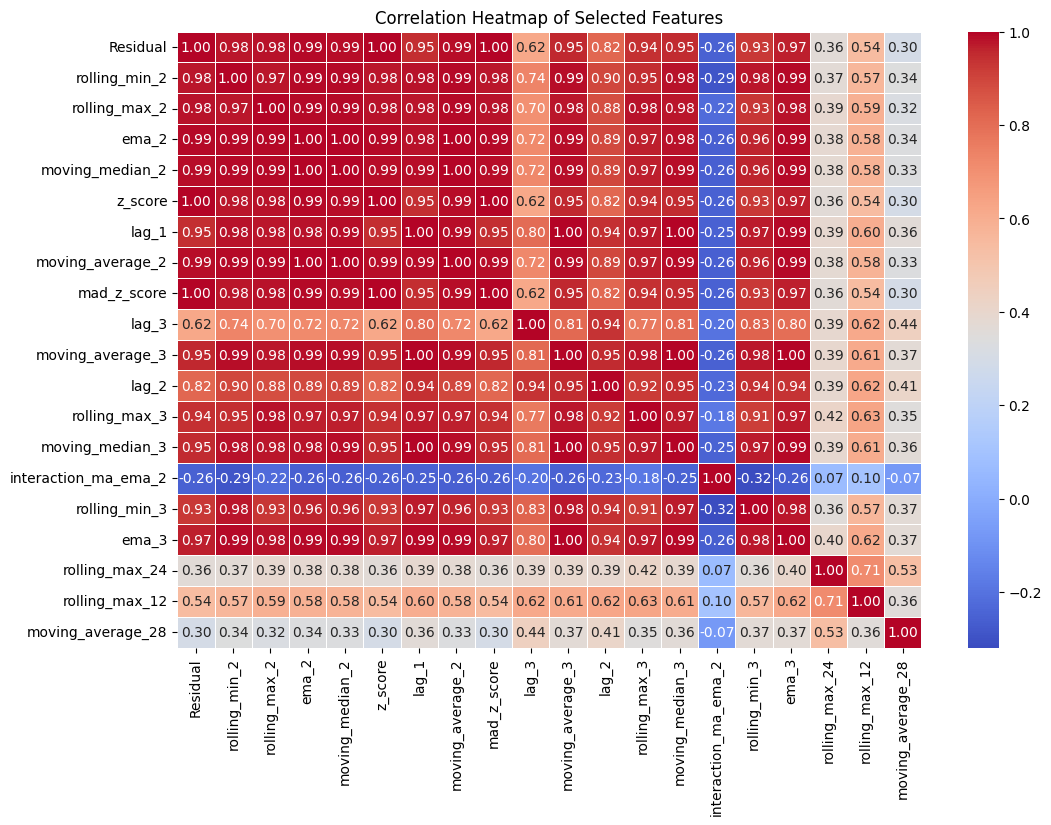

In [12]:
# Calculate and rank features
scores = feature_metrics(features_scaled, scaled_target)
df_scores = pd.DataFrame(scores)
top_n = 20  # Change this to the desired value

# Get ranked scores and top features index
df_scores_ranked, top_features_index = rank_and_top_features(df_scores, top_n=top_n)

# Assuming the features are stored in a DataFrame named 'data_df_drop' with 'Time' as the index
top_features_index_names = data_df_drop.columns[top_features_index]

print(f"\nTop {top_n} Features Index:")
print(top_features_index_names)

# Extract the top features from the original DataFrame
selected_features_df = data_df_drop[top_features_index_names]

correlation_matrix = selected_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

extracted_features_data = selected_features_df.to_numpy()

In [13]:
def prepare_time_series_data(data, time_steps=28, test_size=0.3, random_state=42):
    """
    Prepare time series data for training and testing.

    Parameters:
    - data: The time series data.
    - time_steps: Number of time steps to consider for each sample.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.

    Returns:
    - x_train, x_test, y_train, y_test: Prepared training and testing sets.
    """
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)

    total_samples, num_features = data_scaled.shape
    n_steps = time_steps

    X = []
    y = []

    for i in range(n_steps, len(data_scaled)):
        X.append(data_scaled[i - n_steps:i, :])
        y.append(data_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=False)

    return X, y, x_train, x_test, y_train, y_test

# Example usage:
time_steps = 28
X, y, x_train, x_test, y_train, y_test = prepare_time_series_data(extracted_features_data, time_steps)

print("Training set shapes:")
print(x_train.shape, y_train.shape)

print("\nTesting set shapes:")
print(x_test.shape, y_test.shape)

Training set shapes:
(221, 28, 20) (221,)

Testing set shapes:
(96, 28, 20) (96,)


In [14]:
# Assuming x_train, x_test, y_train, y_test are already prepared
# Using the same shapes you provided (2 time steps, 20 features)

import tensorflow.keras.backend as K

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dense(units=25, activation='relu'))  # Output layer with 1 neuron for regression tasks
model_lstm.add(Dense(units=1))  # Output layer with 1 neuron for regression tasks

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model_lstm.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath1 = 'best_model_lstm.h5'
model_checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint1]
)

Epoch 1/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - loss: 1.5079 - mae: 0.9878 - r_squared: -63.6398
Epoch 1: val_loss improved from inf to 0.39399, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 1.3577 - mae: 0.9042 - r_squared: -58.5757 - val_loss: 0.3940 - val_mae: 0.4675 - val_r_squared: -60.0448
Epoch 2/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0351 - mae: 0.7688 - r_squared: -67.9199
Epoch 2: val_loss improved from 0.39399 to 0.31891, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.0032 - mae: 0.7426 - r_squared: -62.5997 - val_loss: 0.3189 - val_mae: 0.4323 - val_r_squared: -59.0790
Epoch 3/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.9725 - mae: 0.7133 - r_squared: -80.7640
Epoch 3: val_loss improved from 0.31891 to 0.26850, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.8731 - mae: 0.6877 - r_squared: -71.8080 - val_loss: 0.2685 - val_mae: 0.3908 - val_r_squared: -63.4438
Epoch 4/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5717 - mae: 0.5531 - r_squared: -81.7424
Epoch 4: val_loss improved from 0.26850 to 0.22241, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.6474 - mae: 0.5842 - r_squared: -75.1835 - val_loss: 0.2224 - val_mae: 0.3429 - val_r_squared: -70.5689
Epoch 5/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4774 - mae: 0.4966 - r_squared: -95.9108
Epoch 5: val_loss improved from 0.22241 to 0.18974, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.5524 - mae: 0.5427 - r_squared: -81.7559 - val_loss: 0.1897 - val_mae: 0.3098 - val_r_squared: -90.2052
Epoch 6/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3803 - mae: 0.4731 - r_squared: -103.2802
Epoch 6: val_loss improved from 0.18974 to 0.16375, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.4706 - mae: 0.5213 - r_squared: -91.2558 - val_loss: 0.1637 - val_mae: 0.2862 - val_r_squared: -117.2409
Epoch 7/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4155 - mae: 0.4894 - r_squared: -101.9387
Epoch 7: val_loss improved from 0.16375 to 0.14590, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.4070 - mae: 0.4837 - r_squared: -94.8739 - val_loss: 0.1459 - val_mae: 0.2707 - val_r_squared: -156.0782
Epoch 8/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4363 - mae: 0.4917 - r_squared: -96.0589
Epoch 8: val_loss improved from 0.14590 to 0.14161, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3671 - mae: 0.4500 - r_squared: -93.3059 - val_loss: 0.1416 - val_mae: 0.2704 - val_r_squared: -212.2088
Epoch 9/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3063 - mae: 0.4106 - r_squared: -108.5692
Epoch 9: val_loss did not improve from 0.14161
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2791 - mae: 0.3927 - r_squared: -98.2251 - val_loss: 0.1600 - val_mae: 0.2957 - val_r_squared: -299.7185
Epoch 10/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2607 - mae: 0.3704 - r_squared: -109.5608
Epoch 10: val_loss did not improve from 0.14161
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2521 - mae: 0.3742 - r_squared: -100.9916 - val_loss: 0.1971 - val_mae: 0.3262 - val_r_squared: -392.0247
Epoch 11/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3021 - mae: 0.4064 - r_squared: -109.8793
Epoch 11: val_loss did not improve from 0.14161
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2510 - mae: 0.3713 - r_squared: -103.1102

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1033 - mae: 0.2359 - r_squared: -109.4564 - val_loss: 0.1368 - val_mae: 0.2701 - val_r_squared: -232.0658
Epoch 21/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0918 - mae: 0.2218 - r_squared: -125.3316
Epoch 21: val_loss did not improve from 0.13677
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1011 - mae: 0.2303 - r_squared: -111.8701 - val_loss: 0.1542 - val_mae: 0.2877 - val_r_squared: -254.4155
Epoch 22/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1075 - mae: 0.2514 - r_squared: -124.8449
Epoch 22: val_loss improved from 0.13677 to 0.12779, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1012 - mae: 0.2406 - r_squared: -111.4469 - val_loss: 0.1278 - val_mae: 0.2668 - val_r_squared: -254.6323
Epoch 23/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1048 - mae: 0.2239 - r_squared: -118.3560
Epoch 23: val_loss improved from 0.12779 to 0.10709, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0971 - mae: 0.2221 - r_squared: -106.7771 - val_loss: 0.1071 - val_mae: 0.2547 - val_r_squared: -241.8614
Epoch 24/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0942 - mae: 0.2179 - r_squared: -116.1284
Epoch 24: val_loss did not improve from 0.10709
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0887 - mae: 0.2133 - r_squared: -107.1126 - val_loss: 0.1228 - val_mae: 0.2698 - val_r_squared: -261.8063
Epoch 25/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0811 - mae: 0.2025 - r_squared: -121.1997
Epoch 25: val_loss did not improve from 0.10709
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0823 - mae: 0.2063 - r_squared: -110.2100 - val_loss: 0.1600 - val_mae: 0.3068 - val_r_squared: -288.0067
Epoch 26/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0625 - mae: 0.2050 - r_squared: -126.5748
Epoch 26: val_loss did not improve from 0.10709
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0738 - mae: 0.2111 - r_squared: -113.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0613 - mae: 0.1815 - r_squared: -113.1672 - val_loss: 0.1013 - val_mae: 0.2415 - val_r_squared: -233.7189
Epoch 29/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0543 - mae: 0.1714 - r_squared: -122.0373
Epoch 29: val_loss did not improve from 0.10133
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0584 - mae: 0.1789 - r_squared: -110.8405 - val_loss: 0.1112 - val_mae: 0.2540 - val_r_squared: -255.8917
Epoch 30/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0458 - mae: 0.1691 - r_squared: -118.3042
Epoch 30: val_loss did not improve from 0.10133
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0582 - mae: 0.1842 - r_squared: -110.0109 - val_loss: 0.1147 - val_mae: 0.2569 - val_r_squared: -247.6987
Epoch 31/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0489 - mae: 0.1780 - r_squared: -126.9080
Epoch 31: val_loss did not improve from 0.10133
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0559 - mae: 0.1822 - r_squared: -112.

In [15]:
def positional_embedding(inputs, name="positional_embedding"):
    # Get the length of the input sequence
    input_seq_len = inputs.shape[1]

    # Create positional embeddings using an Embedding layer
    # The output dimension is set to the last dimension of the input
    position_embed = layers.Embedding(input_dim=input_seq_len, output_dim=inputs.shape[-1], name=name)(tf.range(input_seq_len))

    # Add positional embeddings to the input
    return inputs + position_embed

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization for input sequence
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head self-attention mechanism
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Residual connection: add the original input to the output of attention mechanism
    res = x + inputs

    # Layer normalization for the residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part:
    # Convolutional layer with a ReLU activation function
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Convolutional layer with the same number of filters as the input dimension
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    # Add the output of the feed-forward part to the residual connection
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):

    # Define the input layer with the specified input shape
    inputs = keras.Input(shape = input_shape)

    # Add positional embedding to the input sequence
    x = positional_embedding(inputs)

    # Loop through the specified number of transformer blocks
    for _ in range(num_transformer_blocks):
        # Apply transformer_encoder function to the input sequence
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Loop through the specified MLP (Multi-Layer Perceptron) units
    for dim in mlp_units:
        # Fully connected layer with ReLU activation function
        x = layers.Dense(dim, activation="relu")(x)

        # Apply dropout for regularization
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer with a single neuron (regression task)
    outputs = layers.Dense(1)(x)

    # Create a Keras Model with the defined input and output layers
    return keras.Model(inputs, outputs)

In [16]:
input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=16,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[256],
#     mlp_dropout=0.2,
#     dropout=0.2,
# )


model = build_model(
    input_shape,
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.2,
)

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath2 = 'best_model_transformer.h5'
model_checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint2]
)

Epoch 1/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.5267 - mae: 0.9313 - r_squared: -70.2174
Epoch 1: val_loss improved from inf to 0.40601, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 1.4931 - mae: 0.9086 - r_squared: -63.3403 - val_loss: 0.4060 - val_mae: 0.5086 - val_r_squared: -44.0189
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1.1372 - mae: 0.7568 - r_squared: -68.3631
Epoch 2: val_loss improved from 0.40601 to 0.36691, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - loss: 1.1190 - mae: 0.7511 - r_squared: -66.2691 - val_loss: 0.3669 - val_mae: 0.4860 - val_r_squared: -52.5499
Epoch 3/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.8170 - mae: 0.6493 - r_squared: -84.1120
Epoch 3: val_loss did not improve from 0.36691
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.8327 - mae: 0.6586 - r_squared: -75.7883 - val_loss: 0.3746 - val_mae: 0.4789 - val_r_squared: -50.3787
Epoch 4/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.7934 - mae: 0.6374 - r_squared: -90.0022
Epoch 4: val_loss did not improve from 0.36691
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.7423 - mae: 0.6216 - r_squared: -83.4151 - val_loss: 0.5046 - val_mae: 0.5519 - val_r_squared: -116.4643
Epoch 5/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4633 - mae: 0.5263 - r_squared: -103.4173
Epoch 5: val_loss did not improve from 0.36691
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.4996 - mae: 0.5409 - r_squared: -91.1918 - val_lo

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0891 - mae: 0.2429 - r_squared: -108.1442 - val_loss: 0.3386 - val_mae: 0.4555 - val_r_squared: -84.5676
Epoch 43/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1009 - mae: 0.2441 - r_squared: -121.8909
Epoch 43: val_loss did not improve from 0.33865
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0995 - mae: 0.2439 - r_squared: -108.6112 - val_loss: 0.4152 - val_mae: 0.4969 - val_r_squared: -92.6091
Epoch 44/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0883 - mae: 0.2436 - r_squared: -131.9267
Epoch 44: val_loss did not improve from 0.33865
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0862 - mae: 0.2408 - r_squared: -118.1857 - val_loss: 0.5299 - val_mae: 0.5641 - val_r_squared: -109.4115
Epoch 45/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1041 - mae: 0.2444 - r_squared: -125.8612
Epoch 45: val_loss did not improve from 0.33865
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1082 - mae: 0.2512 - r_squared: -113.4

In [17]:
def plot_true_vs_predicted(model, x_data, y_true, scaler):
    # Predict using the model and input data
    y_pred = model.predict(x_data)

    # Inverse transform the standardized target variable
    inverse_scaled_y_true = scaler.inverse_transform(y_true.reshape(-1, 1))
    inverse_scaled_y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Plotting True vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.plot(inverse_scaled_y_true, label='True Values')
    plt.plot(inverse_scaled_y_pred, label='Predicted Values', linestyle='--')
    plt.title('True vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return y_pred

# Prepare the last 120 data for prediction
x_final = X[-120:, :, :]
y_final = y[-120:]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


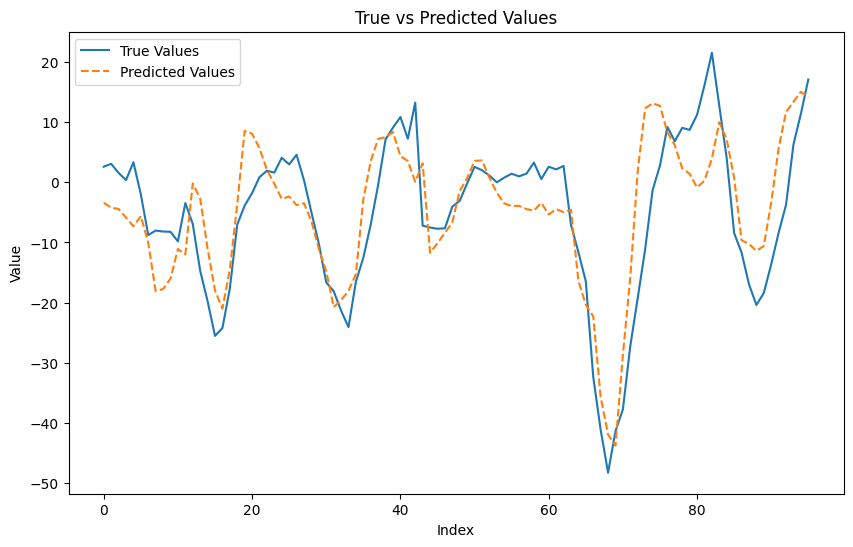

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


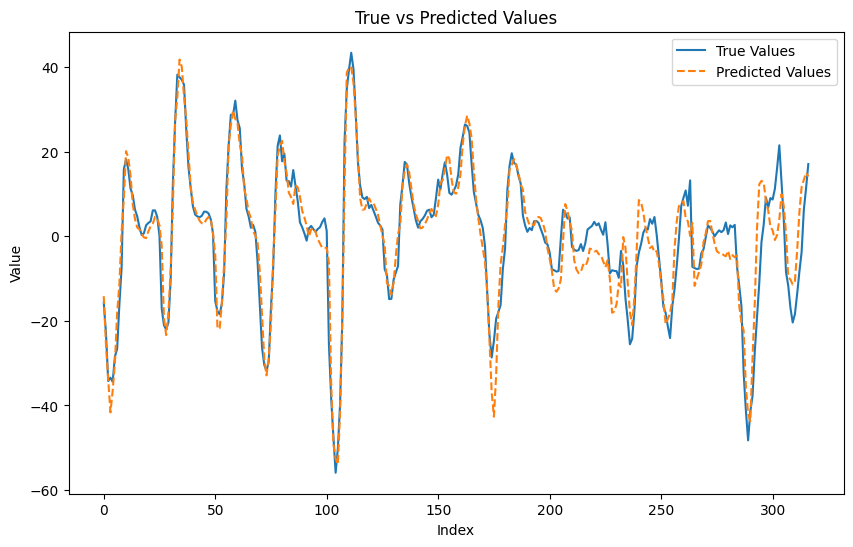

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


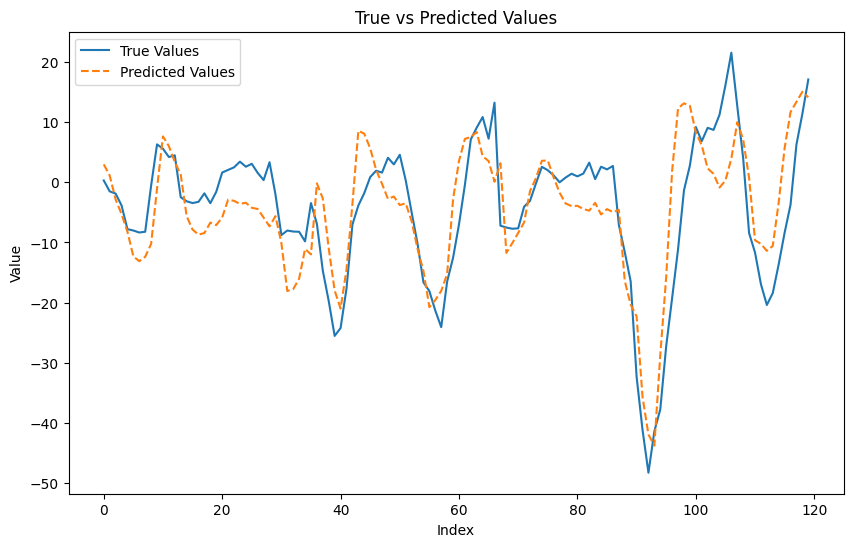

In [18]:
best_model1 = load_model(checkpoint_filepath1, custom_objects={'r_squared': r_squared})
y_test_pred1 = plot_true_vs_predicted(best_model1, x_test, y_test, target_scaler)
y_pred1 = plot_true_vs_predicted(best_model1, X, y, target_scaler)
y_final_pred1 = plot_true_vs_predicted(best_model1, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final1 = target_scaler.inverse_transform(y_final_pred1.reshape(-1, 1))
inverse_scaled_y_Predict1 = target_scaler.inverse_transform(y_pred1.reshape(-1, 1))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


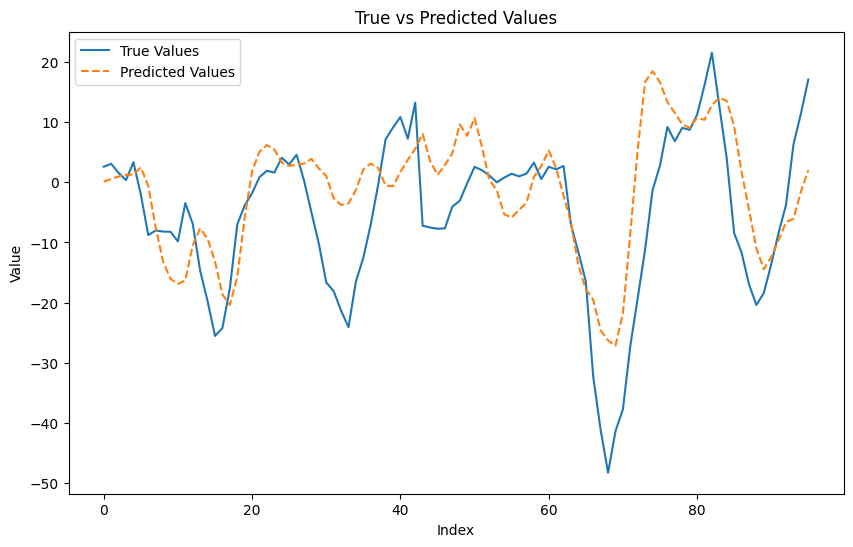

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


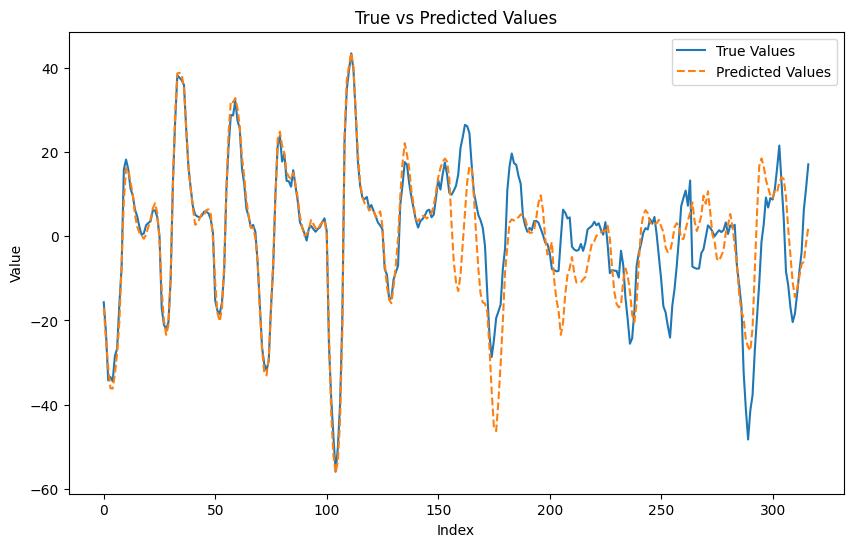

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


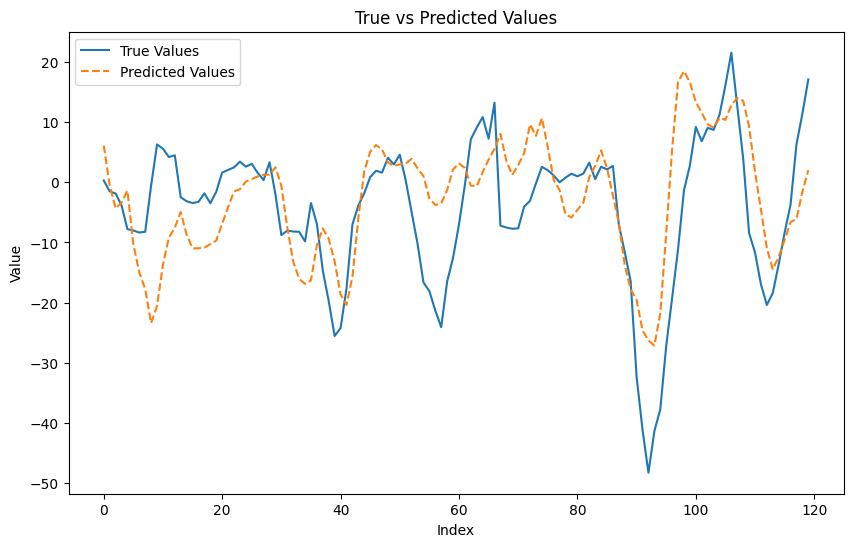

In [19]:
model.save('best_model_transformer.keras')

best_model2 = load_model('best_model_transformer.keras', custom_objects={'r_squared': r_squared})
## best_model2 = load_model(checkpoint_filepath2, custom_objects={'r_squared': r_squared})
y_test_pred2 = plot_true_vs_predicted(best_model2, x_test, y_test, target_scaler)
y_pred2 = plot_true_vs_predicted(best_model2, X, y, target_scaler)
y_final_pred2 = plot_true_vs_predicted(best_model2, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final2 = target_scaler.inverse_transform(y_final_pred2.reshape(-1, 1))
inverse_scaled_y_Predict2 = target_scaler.inverse_transform(y_pred2.reshape(-1, 1))

In [20]:
# 1. Prediksi data training dan testing
y_train_pred = best_model2.predict(x_train)
y_test_pred = best_model2.predict(x_test)

# Inverse transform data training (aktual & prediksi)
inverse_scaled_y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

# Inverse transform data testing (aktual & prediksi)
inverse_scaled_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


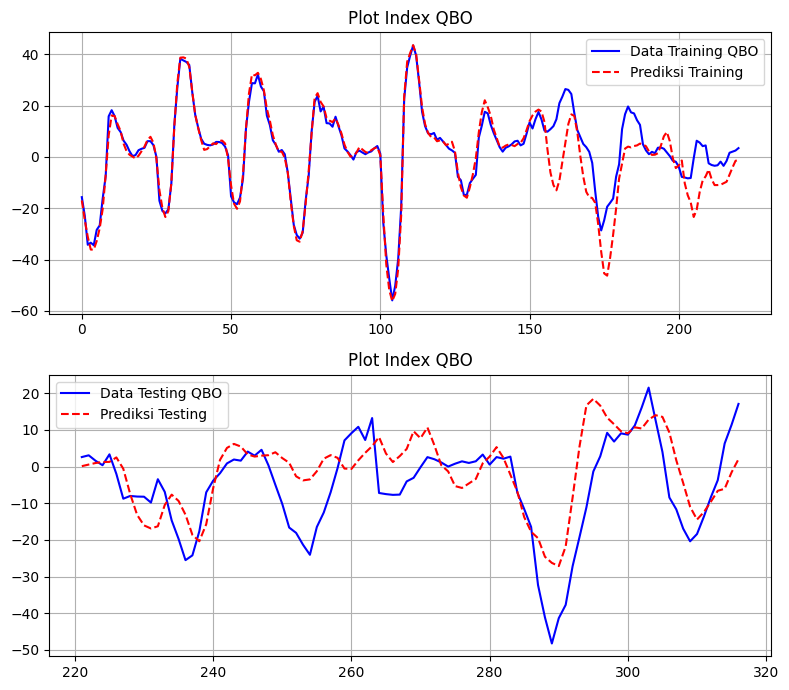

In [21]:
# Asumsikan variabel berikut sudah ada dan sudah inverse_transform:
inverse_scaled_y_train, inverse_scaled_y_train_pred
inverse_scaled_y_test, inverse_scaled_y_test_pred

# Untuk mendapatkan index global pada data test (misal setelah train 0-369, test 370-419)
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(8, 7))

# --------- Subplot 1: Data Training ----------
plt.subplot(2, 1, 1)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Data Training QBO')
plt.plot(train_idx, inverse_scaled_y_train_pred, 'r--', label='Prediksi Training')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

# --------- Subplot 2: Data Testing ----------
plt.subplot(2, 1, 2)
plt.plot(test_idx, inverse_scaled_y_test, 'b-', label='Data Testing QBO')
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Prediksi Testing')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [23]:
def calculate_metrics_and_print(original_data, predictions):
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Log Likelihood
    residuals = original_data - predictions
    log_likelihood = np.sum(norm.logpdf(residuals))

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

In [24]:
calculate_metrics_and_print(y, y_pred1)

Metrics for Original Data Model:
MSE:  0.12959350608505762
RMSE:  0.35999098056070467
R-squared:  0.8796376701556724
MAE:  0.2630176682743983
Log Likelihood:  -198086.86857170757
MAPE:  575.0304556624178


In [25]:
calculate_metrics_and_print(y, y_pred2)

Metrics for Original Data Model:
MSE:  0.27609103173694094
RMSE:  0.5254436522948402
R-squared:  0.7435754241638348
MAE:  0.3365399491468272
Log Likelihood:  -201357.18303956714
MAPE:  591.5111869548531


In [26]:
calculate_metrics_and_print(y_test,y_test_pred1)

Metrics for Original Data Model:
MSE:  0.25507022706999144
RMSE:  0.5050447772920649
R-squared:  0.6382385407563227
MAE:  0.4070701716815637
Log Likelihood:  -14189.458014330467
MAPE:  628.8370779576405


In [27]:
calculate_metrics_and_print(y_test,y_test_pred2)

Metrics for Original Data Model:
MSE:  0.41774537323920274
RMSE:  0.6463322467889118
R-squared:  0.40751934260896683
MAE:  0.5064545347928663
Log Likelihood:  -13909.27156633445
MAPE:  531.739025855044


In [28]:
inverse_scaled_target = target_scaler.inverse_transform(y.reshape(-1, 1))
inverse_scaled_y_final = target_scaler.inverse_transform(y_final.reshape(-1, 1))

In [29]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict1)

Metrics for Original Data Model:
MSE:  31.282529492911934
RMSE:  5.5930787132769675
R-squared:  0.8796376699806961
MAE:  4.086431618255625
Log Likelihood:  -5249.584439652423
MAPE:  300.48775186009505


In [30]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict2)

Metrics for Original Data Model:
MSE:  66.64551487760481
RMSE:  8.163670429261877
R-squared:  0.743575420976675
MAE:  5.228726650606984
Log Likelihood:  -10854.61762312624
MAPE:  263.5291063879074


In [31]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final1)

Metrics for Original Data Model:
MSE:  53.8126692650906
RMSE:  7.335711912629244
R-squared:  0.6221150782625378
MAE:  5.891420360063796
Log Likelihood:  -3339.032779889997
MAPE:  642.7907896564126


In [32]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final2)

Metrics for Original Data Model:
MSE:  102.80404931029015
RMSE:  10.139233171709296
R-squared:  0.2780863566432529
MAE:  7.956994186058565
Log Likelihood:  -6278.515582601971
MAPE:  594.4103825406221


In [33]:
# --- LSTM ---
# Prediksi di data test (10%)
y_test_pred_lstm = best_model1.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_lstm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_lstm = target_scaler.inverse_transform(y_test_pred_lstm.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (LSTM)
print("=== Metrics Test Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_test_lstm, inverse_scaled_y_test_pred_lstm)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_lstm = best_model1.predict(x_train)
inverse_scaled_y_train_lstm = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_lstm = target_scaler.inverse_transform(y_train_pred_lstm.reshape(-1, 1))
print("=== Metrics Train Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_train_lstm, inverse_scaled_y_train_pred_lstm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
=== Metrics Test Set - LSTM ===
Metrics for Original Data Model:
MSE:  61.571309203987994
RMSE:  7.846738762313168
R-squared:  0.6382385432720721
MAE:  6.324534892253521
Log Likelihood:  -3043.640940979072
MAPE:  743.4067138203766
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
=== Metrics Train Set - LSTM ===
Metrics for Original Data Model:
MSE:  18.12541365743548
RMSE:  4.2573951728064285
R-squared:  0.9352778921652342
MAE:  3.1142239626336705
Log Likelihood:  -2205.943624984853
MAPE:  108.0885664521243


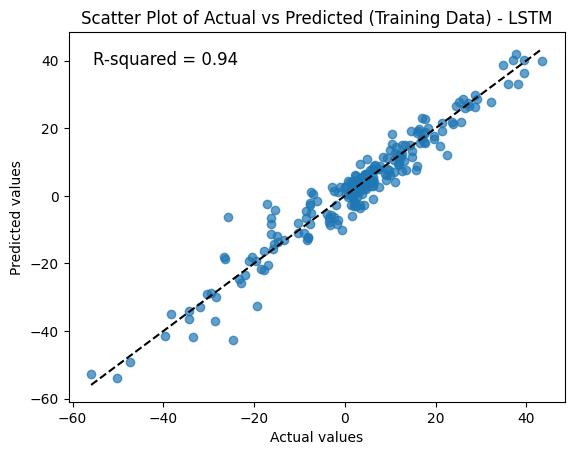

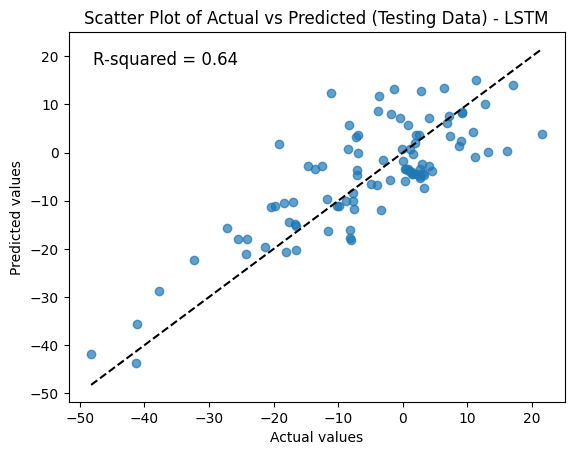

In [34]:
def plot_r2_scatter(y_true, y_pred, title, ax=None):
    r2 = r2_score(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, alpha=0.7)
    # Garis diagonal y=x
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.text(0.05, 0.95, f'R-squared = {r2:.2f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')
    ax.set_title(title)
    ax.set_xlabel("Actual values")
    ax.set_ylabel("Predicted values")

# --- LSTM ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_lstm, 
    inverse_scaled_y_train_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Training Data) - LSTM"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_lstm, 
    inverse_scaled_y_test_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - LSTM"
)
plt.show()

In [35]:
# --- TRANSFORMER ---
# Prediksi di data test (10%)
y_test_pred_transformer = best_model2.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_transformer = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_transformer = target_scaler.inverse_transform(y_test_pred_transformer.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (Transformer)
print("=== Metrics Test Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_test_transformer, inverse_scaled_y_test_pred_transformer)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_transformer = best_model2.predict(x_train)
inverse_scaled_y_train_transformer = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_transformer = target_scaler.inverse_transform(y_train_pred_transformer.reshape(-1, 1))
print("=== Metrics Train Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_train_transformer, inverse_scaled_y_train_pred_transformer)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
=== Metrics Test Set - Transformer ===
Metrics for Original Data Model:
MSE:  100.83940435486466
RMSE:  10.041882510508906
R-squared:  0.40751934161196
MAE:  7.868641815362698
Log Likelihood:  -4928.50950822115
MAPE:  628.1467119899529
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
=== Metrics Train Set - Transformer ===
Metrics for Original Data Model:
MSE:  51.792060166010785
RMSE:  7.19667007483397
R-squared:  0.8150612523166265
MAE:  4.081976181778129
Log Likelihood:  -5926.108064182425
MAPE:  105.14317895149638


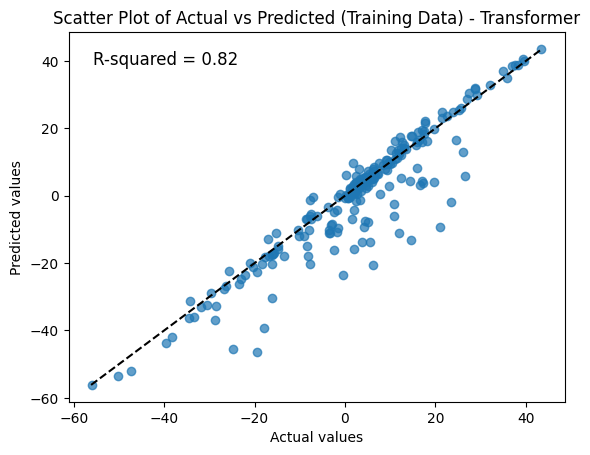

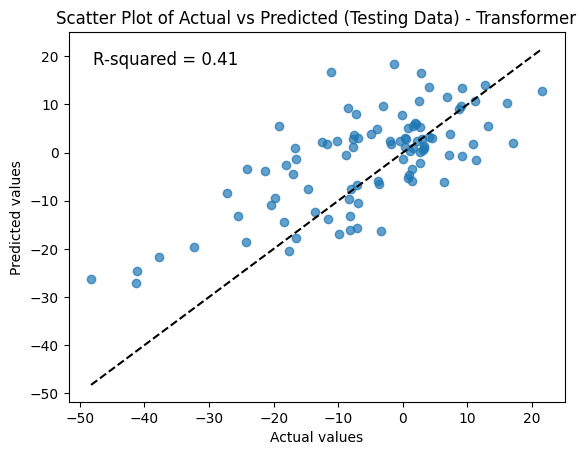

In [36]:
# --- TRANSFORMER ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_transformer, 
    inverse_scaled_y_train_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Training Data) - Transformer"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_transformer, 
    inverse_scaled_y_test_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - Transformer"
)
plt.show()

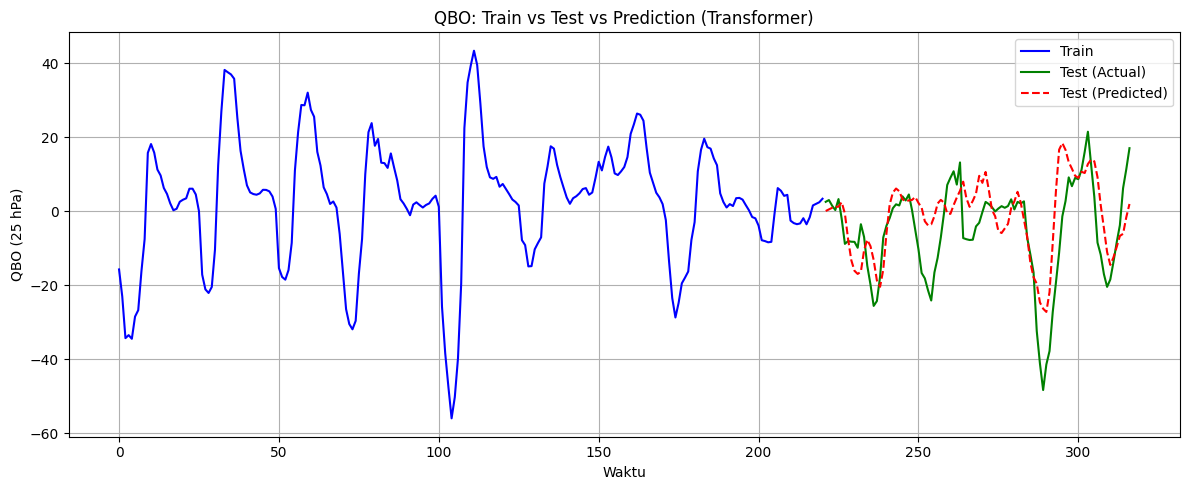

In [37]:
# Misal train_len = jumlah data train
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(12,5))

# Plot data train (aktual)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Train')

# Plot data test (aktual)
plt.plot(test_idx, inverse_scaled_y_test, 'g-', label='Test (Actual)')

# Plot data test (prediksi)
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Test (Predicted)')

plt.title('QBO: Train vs Test vs Prediction (Transformer)')
plt.xlabel('Waktu')
plt.ylabel('QBO (25 hPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

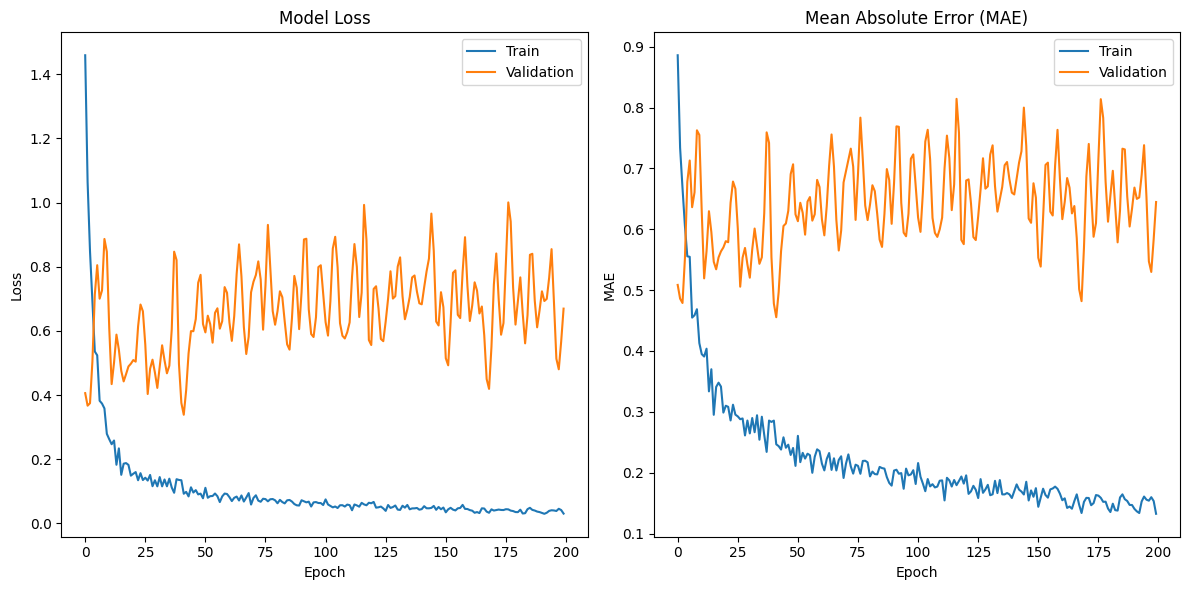

In [38]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [39]:
residuals1 = inverse_scaled_target - inverse_scaled_y_Predict1
residuals_final1 = inverse_scaled_y_final - inverse_scaled_y_pred_final1

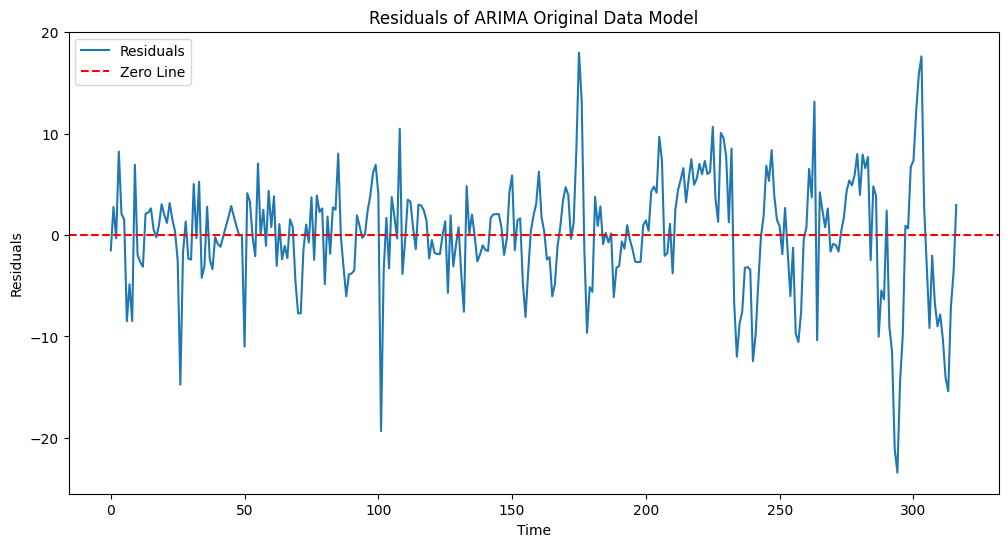

In [40]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

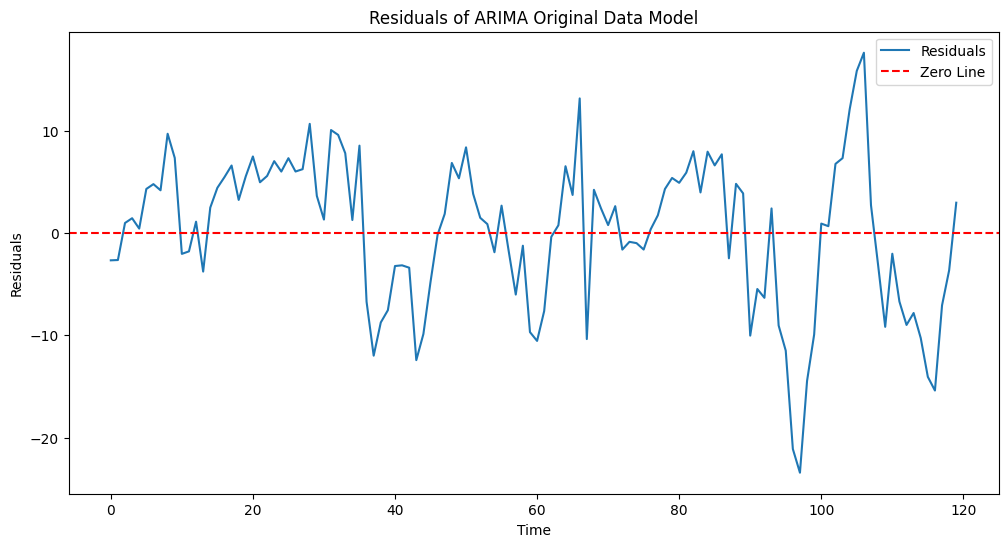

In [41]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [42]:
residuals2 = inverse_scaled_target - inverse_scaled_y_Predict2
residuals_final2 = inverse_scaled_y_final - inverse_scaled_y_pred_final2

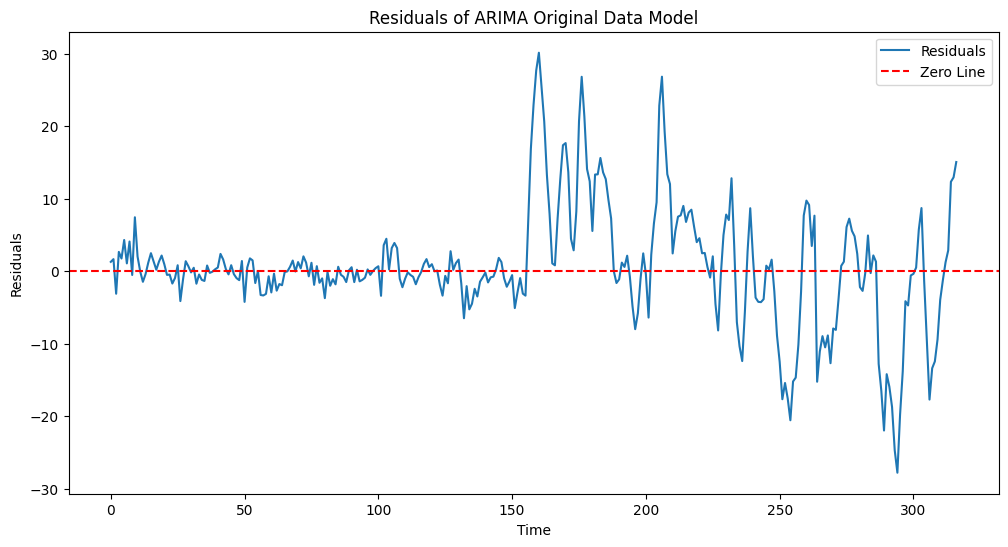

In [43]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

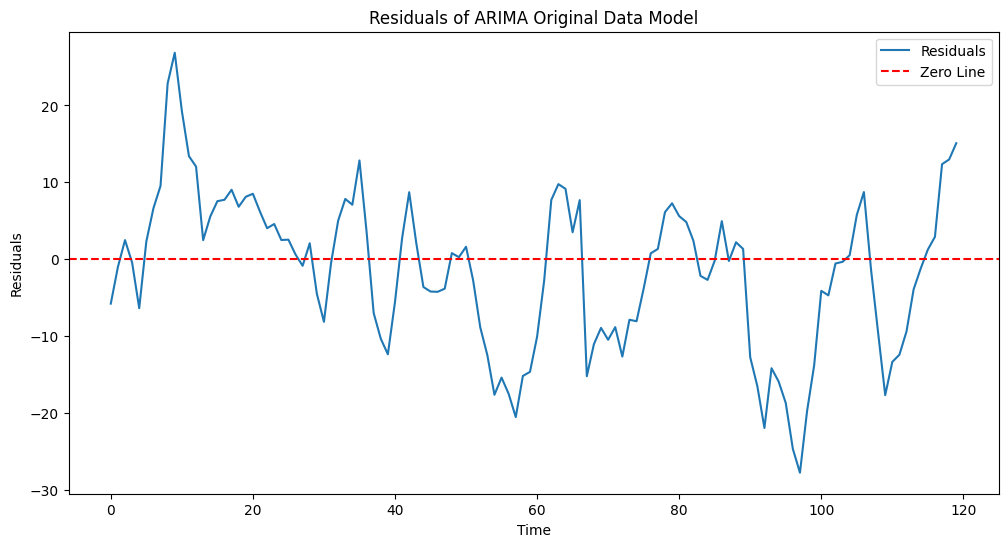

In [44]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [45]:
def residual_analysis(residuals):
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test (Normality):")
    print("Test Statistic:", stat)
    print("P-value:", p_value)
    if p_value > 0.05:
        print("The residuals appear to be normally distributed.")
    else:
        print("The residuals may not be normally distributed.")

    # Anderson-Darling Test for normality
    result = anderson(residuals)
    test_statistic = result.statistic
    critical_values = result.critical_values

    # Plot ACF and PACF on residuals
    plt.figure(figsize=(12, 6))
    acf_res = plot_acf(residuals, title='ACF of Residuals')
    pacf_res = plot_pacf(residuals, title='PACF of Residuals')
    plt.show()

    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9653670244124234
P-value: 7.219347994410649e-07
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

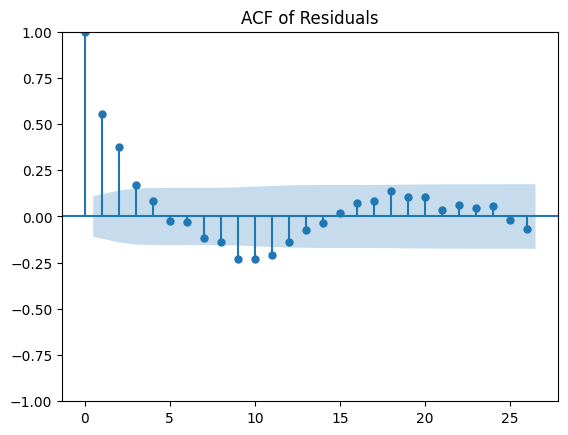

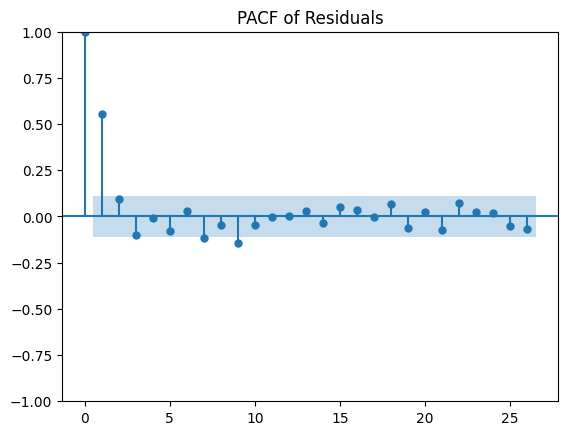

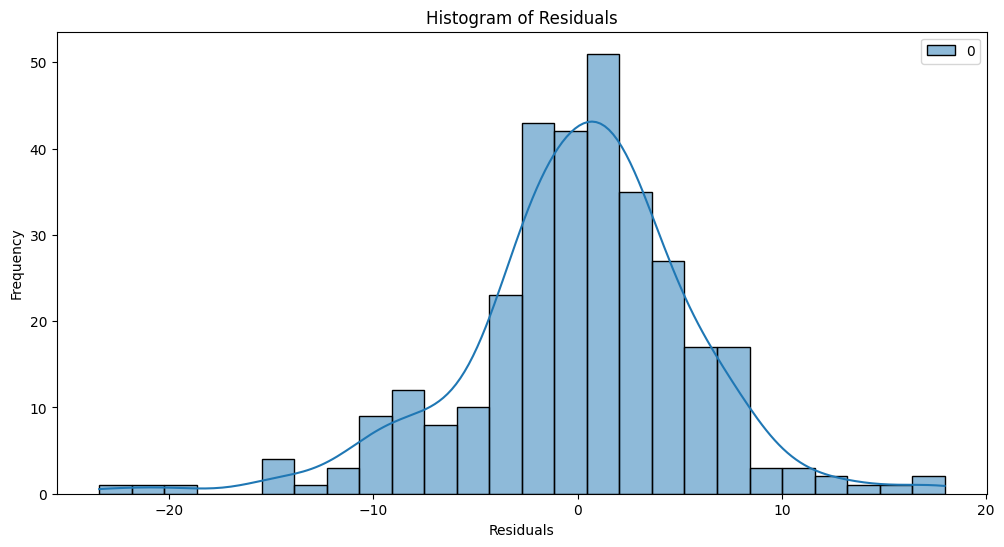

In [46]:
residual_analysis(residuals1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9712257343557716
P-value: 0.011252843267462793
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

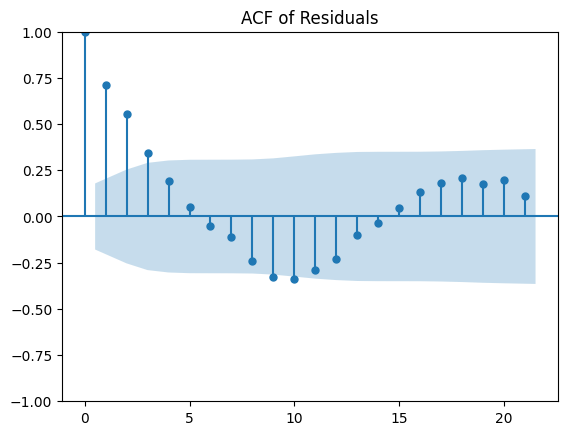

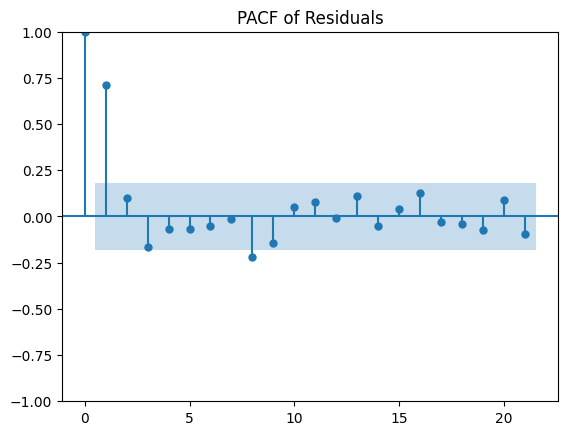

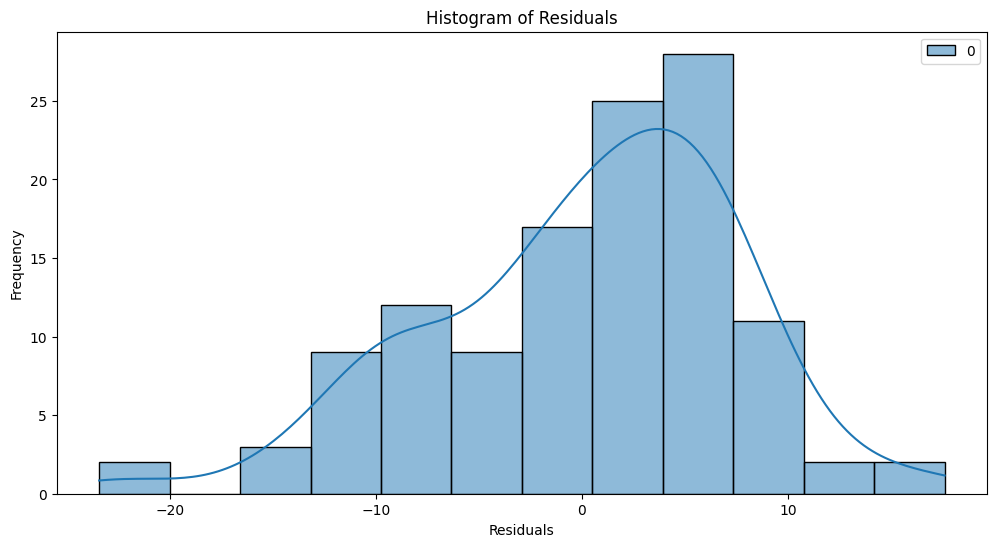

In [47]:
residual_analysis(residuals_final1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.916877821933803
P-value: 3.0052489895752226e-12
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

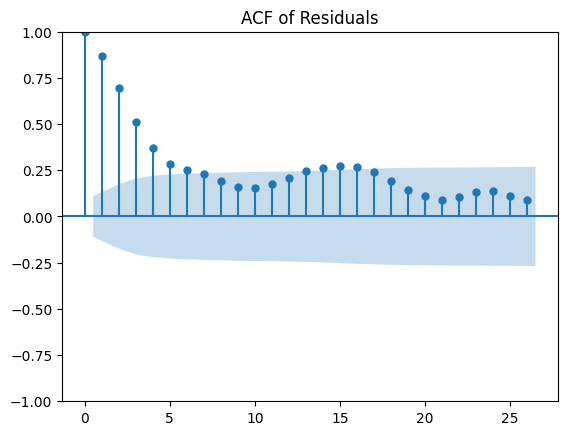

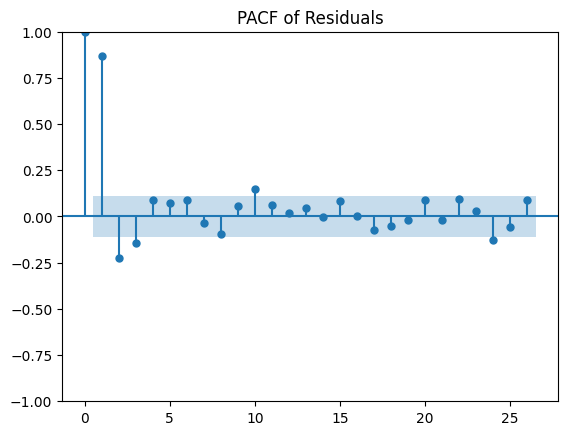

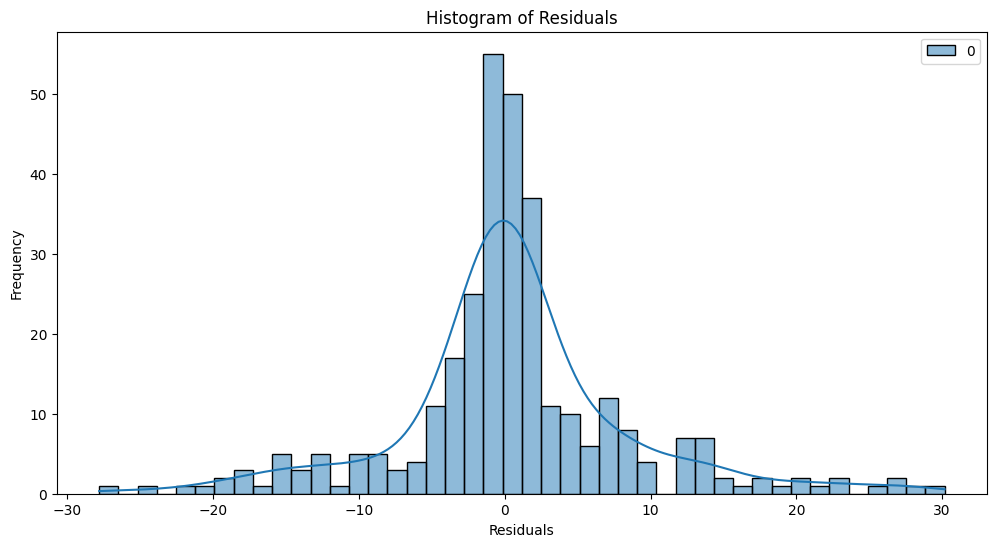

In [48]:
residual_analysis(residuals2)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9872307342891673
P-value: 0.3222109677145495
The residuals appear to be normally distributed.


<Figure size 1200x600 with 0 Axes>

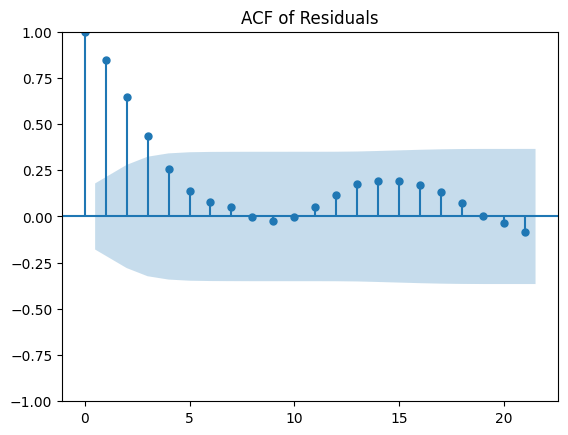

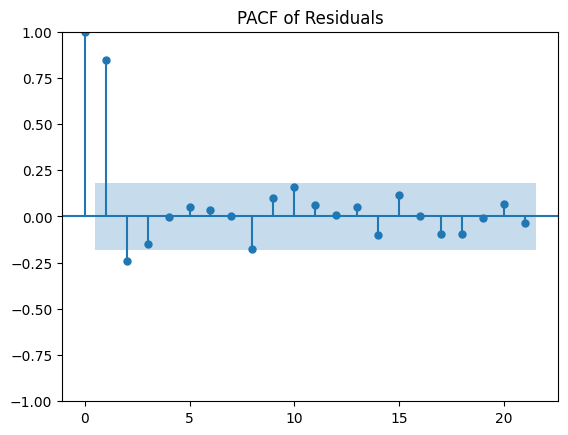

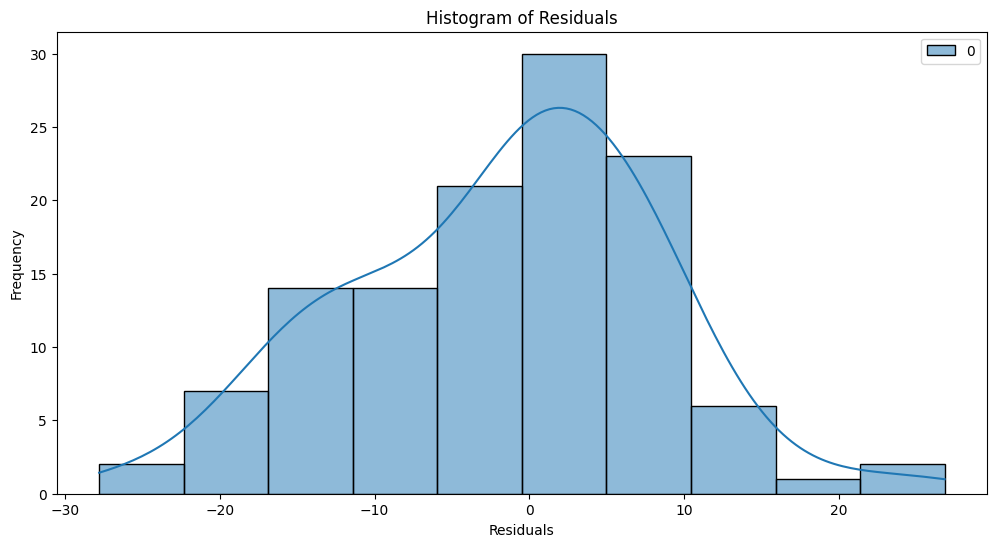

In [49]:
residual_analysis(residuals_final2)